<a href="https://colab.research.google.com/github/KimchiLim/algo-trading/blob/main/algo_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [132]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler

# Fetch historical data for Apple Inc.
ticker = 'AAPL'
data = yf.download(ticker, start='2015-1-1', end='2018-1-1')

[*********************100%***********************]  1 of 1 completed


In [189]:
# Display the first few rows of the dataset
print(data.head())

Price       Adj Close      Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                                        
2015-01-02  24.347170  27.332500  27.860001  26.837500  27.847500  212818400
2015-01-05  23.661272  26.562500  27.162500  26.352501  27.072500  257142000
2015-01-06  23.663504  26.565001  26.857500  26.157499  26.635000  263188400
2015-01-07  23.995316  26.937500  27.049999  26.674999  26.799999  160423600
2015-01-08  24.917273  27.972500  28.037500  27.174999  27.307501  237458000


Text(0, 0.5, 'Open Price')

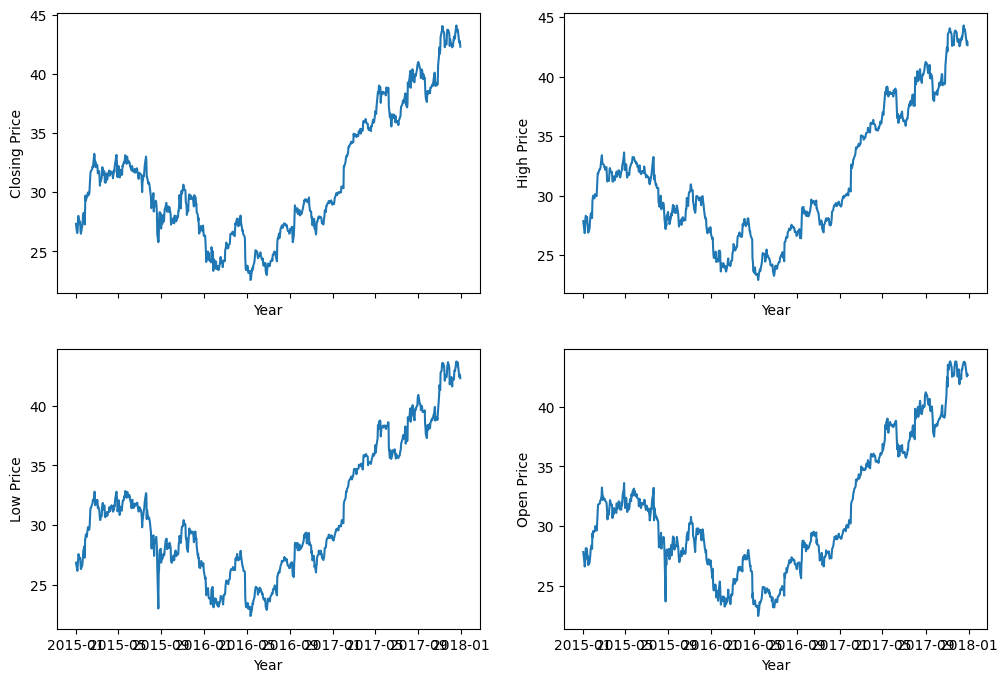

In [190]:
# Visualize the data
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), sharex=True)

axs[0, 0].plot(data['Close'])
axs[0, 0].set_xlabel('Year')
axs[0, 0].set_ylabel('Closing Price')

axs[0, 1].plot(data['High'])
axs[0, 1].set_xlabel('Year')
axs[0, 1].set_ylabel('High Price')

axs[1, 0].plot(data['Low'])
axs[1, 0].set_xlabel('Year')
axs[1, 0].set_ylabel('Low Price')

axs[1, 1].plot(data['Open'])
axs[1, 1].set_xlabel('Year')
axs[1, 1].set_ylabel('Open Price')


In [191]:
# Creating training and testing data for LSTM model
def load_data(stock, look_back, features, test_split=0.2):
  raw_data = stock[features].values
  scaler = StandardScaler()
  scaler.fit(raw_data)
  scaled_data = scaler.transform(raw_data)
  data = []
  for i in range(len(scaled_data) - look_back + 1):
    data.append(scaled_data[i:i+look_back])

  data = np.array(data)

  test_size = int(len(data) * test_split)
  train_size = len(data) - test_size

  X_train = data[:train_size, :-1]
  y_train = data[:train_size, -1, :1]

  X_test = data[train_size:, :-1]
  y_test = data[train_size:, -1, :1]

  y_test_actual = raw_data[train_size + look_back - 1:, 0]

  return [X_train, y_train, X_test, y_test, y_test_actual]

In [192]:
look_back = 30
features = ['Close', 'Open', 'High', 'Low']
X_train, y_train, X_test, y_test, y_test_actual = load_data(data, look_back, features)

X_train = torch.from_numpy(X_train).type(torch.Tensor)
X_test = torch.from_numpy(X_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [193]:
# Build model
#####################
input_dim = len(features)
hidden_dim = 64
num_layers = 3
output_dim = 1


# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        out, _ = self.lstm(x)
        res = self.fc(out[:, -1, :])
        return res

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [194]:
# Train model
#####################
num_epochs = 100
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim = look_back-1

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    # model.hidden = model.init_hidden()

    # Forward pass
    y_train_pred = model(X_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.10045675933361053
Epoch  20 MSE:  0.04703971743583679
Epoch  30 MSE:  0.011596455238759518
Epoch  40 MSE:  0.010396745055913925
Epoch  50 MSE:  0.008439721539616585
Epoch  60 MSE:  0.007867982611060143
Epoch  70 MSE:  0.007398063782602549
Epoch  80 MSE:  0.007087953854352236
Epoch  90 MSE:  0.00679838377982378


In [217]:
y_test_pred = model(X_test)
accuracy = 1 - torch.mean(((y_test - y_test_pred) / y_test))
print(f"Accuracy: {accuracy: .3f}%")

Accuracy:  0.947%


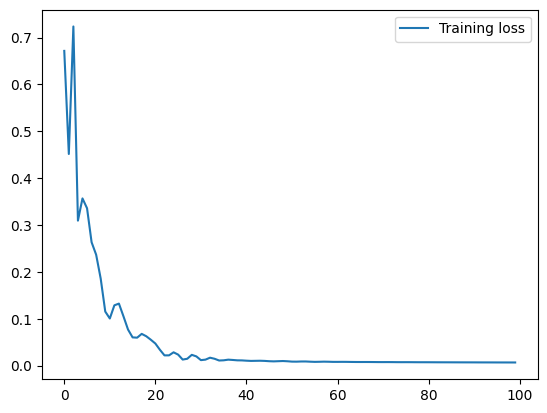

In [218]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

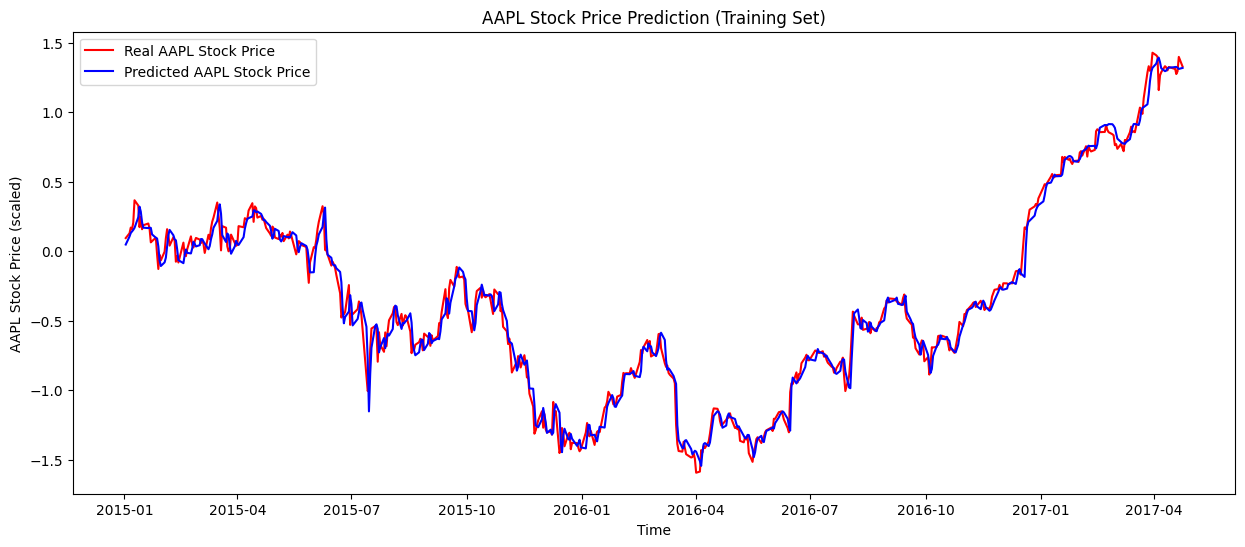

In [219]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(data[:len(y_train)].index, y_train, color = 'red', label = 'Real AAPL Stock Price')
axes.plot(data[:len(y_train)].index, y_train_pred.detach().numpy(), color = 'blue', label = 'Predicted AAPL Stock Price')

plt.title('AAPL Stock Price Prediction (Training Set)')
plt.xlabel('Time')
plt.ylabel('AAPL Stock Price (scaled)')

plt.legend()
plt.show()

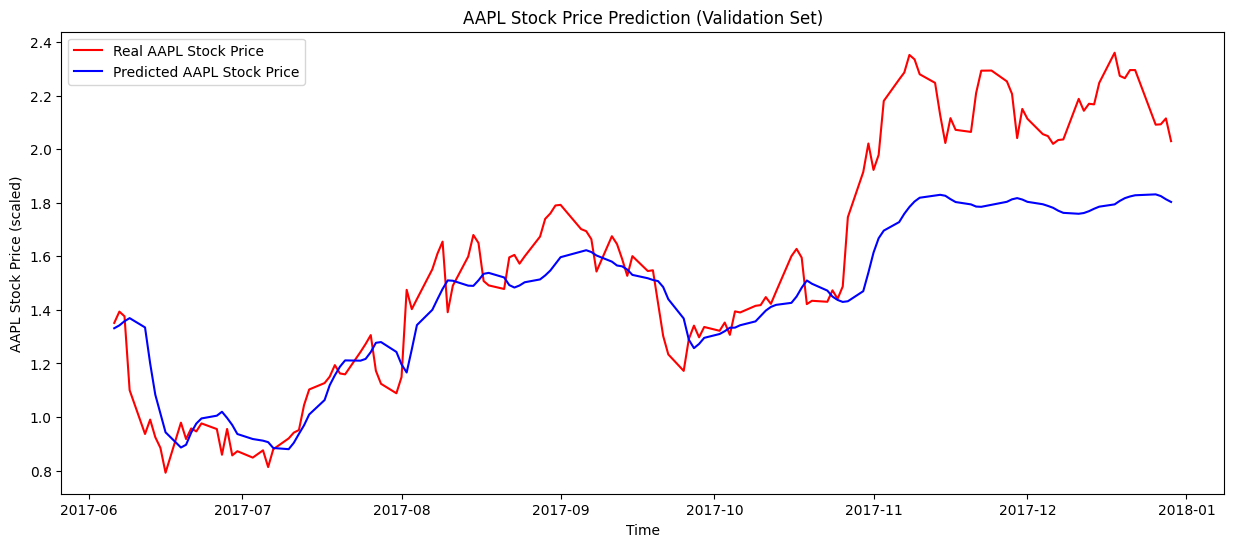

In [220]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(data[len(y_train) + look_back - 1:].index, y_test, color = 'red', label = 'Real AAPL Stock Price')
axes.plot(data[len(y_train) + look_back - 1:].index, y_test_pred.detach().numpy(), color = 'blue', label = 'Predicted AAPL Stock Price')

plt.title('AAPL Stock Price Prediction (Validation Set)')
plt.xlabel('Time')
plt.ylabel('AAPL Stock Price (scaled)')

plt.legend()
plt.show()

In [228]:
# Simple day trading strategy: Buy when price is undervalued (relative to prediction) and sell when overvalued

cash = 1000
volume = 0
num_days = len(y_test_pred)
for i in range(num_days-1):

  if y_test[i, 0] < y_test_pred[i+1, 0]:
    buy_volume = cash // y_test_actual[i]
    price = buy_volume * y_test_actual[i]
    cash -= price
    volume += buy_volume
  else:
    cash += y_test_actual[i] * volume
    volume = 0

assets = cash + volume * y_test_actual[-1]
print(f"Cash: {cash: .2f}$, Volume: {volume}, Total Assets: {assets: .2f}$")
print(f"Earned {assets - 1000: .2f}$ in 186 days. Average annual return: {(assets / 1000) ** (365 / 186) * 100: .2f}%")

Cash:  1131.75$, Volume: 0, Total Assets:  1131.75$
Earned  131.75$ in 186 days. Average annual return:  127.49%
